### Project 7 

In this project, you will use PCA and clustering techniques to discover trends and meaningful grouping of U.S. Airports which are experiencing delays. The goal is to *generate supportable hypotheses* which could later be further investigated with summary or descriptive statistics.  

#### Step 1: Load libraries 

In [199]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import normaltest
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import silhouette_score
from sklearn.dummy import DummyClassifier

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet



from scipy.spatial.distance import pdist
import pylab
import seaborn as sns

plt.style.use("ggplot")

%matplotlib inline

#### Step 2: Examine data 

In [2]:
## Import cancellations data
df_raw = pd.read_csv("assets/airport_cancellations.csv")
df = df_raw.dropna() 

df.columns = [i.lower().replace(" ","_") for i in df.columns]
df.head(2)
# print len(df)


,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0


In [3]:
##import operations data

df_ops = pd.read_csv("assets/Airport_operations.csv")
df_ops = df_ops.dropna()
df_ops.columns = [i.lower().replace(" ","_") for i in df_ops.columns]

print len(df_ops)
df_ops.head(2)

841


,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


In [4]:
## Import all airports df

df_ports = pd.read_csv("assets/airports.csv")
df_ports = df_ports.dropna()
df_ports.columns = [i.lower().replace(" ","_") for i in df_ports.columns]

print len(df_ports)
df_ports.head(2)

3498


,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes


In [5]:
## Merge these together
newdf = df_ops.merge(df,how = 'left', on = ["airport", 'year'])

In [123]:
newdf.describe()

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
count,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,799.000000,799.000000,799.000000,799.000000
mean,2009.028537,108257.063020,107815.561237,0.764119,0.714283,0.754281,13.561403,13.703389,3.519750,16.249964,2.921237,1.348894,3.330773,14.013222,1299.314143,1341.068836,174.250313,170.256571
std,3.156497,98278.401526,97916.908601,0.093361,0.101271,0.082302,4.746563,3.792181,2.391278,5.353012,1.201453,0.882252,1.026872,4.482215,1840.877193,1980.459892,172.638408,229.162686
min,2004.000000,261.000000,259.000000,0.246700,0.245700,0.324100,5.350000,7.040000,0.000000,6.290000,0.950000,0.000000,1.230000,6.330000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,37653.000000,37502.000000,0.745700,0.684800,0.737500,10.910000,11.260000,2.210000,12.950000,2.050000,0.800000,2.630000,11.300000,NaN,NaN,NaN,NaN
50%,2009.000000,72043.000000,71254.000000,0.782500,0.737200,0.768300,12.640000,12.810000,2.990000,15.220000,2.650000,1.080000,3.160000,13.080000,NaN,NaN,NaN,NaN
75%,2012.000000,162913.000000,160775.000000,0.809800,0.772200,0.796500,14.950000,15.650000,4.080000,17.940000,3.620000,1.740000,3.860000,15.250000,NaN,NaN,NaN,NaN
max,2014.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,40.800000,35.760000,18.940000,40.870000,7.820000,6.180000,7.520000,34.880000,16618.000000,17571.000000,1064.000000,1948.000000


In [175]:
df_04 = newdf[newdf['year'] == 2004].dropna()

In [149]:
df_04.head(2)

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87,242.0,235.0,71.0,46.0
11,ANC,2004,16503,15511,0.7109,0.6770,0.6502,21.45,12.41,2.92,23.05,4.03,1.08,5.93,22.62,473.0,532.0,73.0,30.0


In [150]:
df_04[df_04['departure_cancellations'].isnull() ]

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
242,GYY,2004,261,259,0.5556,0.5939,0.5985,22.30,9.11,0.00,21.11,4.83,0.00,4.07,22.46,NaN,NaN,NaN,NaN
646,RFD,2004,1946,1935,0.6912,0.6598,0.7907,13.20,7.04,1.78,14.50,2.27,0.81,3.60,11.39,NaN,NaN,NaN,NaN
797,TEB,2004,28711,28964,0.2889,0.3104,0.3800,38.41,9.11,0.00,36.89,6.28,0.00,6.09,31.14,NaN,NaN,NaN,NaN
830,VNY,2004,1331,1301,0.2900,0.3178,0.3920,35.15,9.20,0.00,33.65,3.71,0.00,3.33,32.86,NaN,NaN,NaN,NaN


In [130]:
df_04.columns

Index([u'airport', u'year', u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'percent_on-time_gate_departures',
       u'percent_on-time_airport_departures', u'percent_on-time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay',
       u'departure_cancellations', u'arrival_cancellations',
       u'departure_diversions', u'arrival_diversions'],
      dtype='object')

In [176]:
features = [col for col in df_04.columns if col not in ['year', 'airport']]



In [177]:
X = StandardScaler().fit_transform(df_04[features])


In [178]:
df_04.columns


Index([u'airport', u'year', u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'percent_on-time_gate_departures',
       u'percent_on-time_airport_departures', u'percent_on-time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay',
       u'departure_cancellations', u'arrival_cancellations',
       u'departure_diversions', u'arrival_diversions'],
      dtype='object')

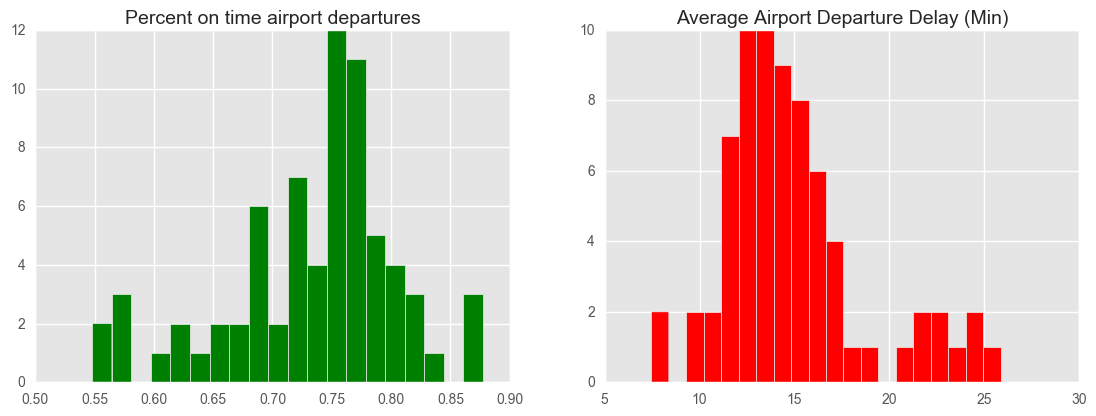

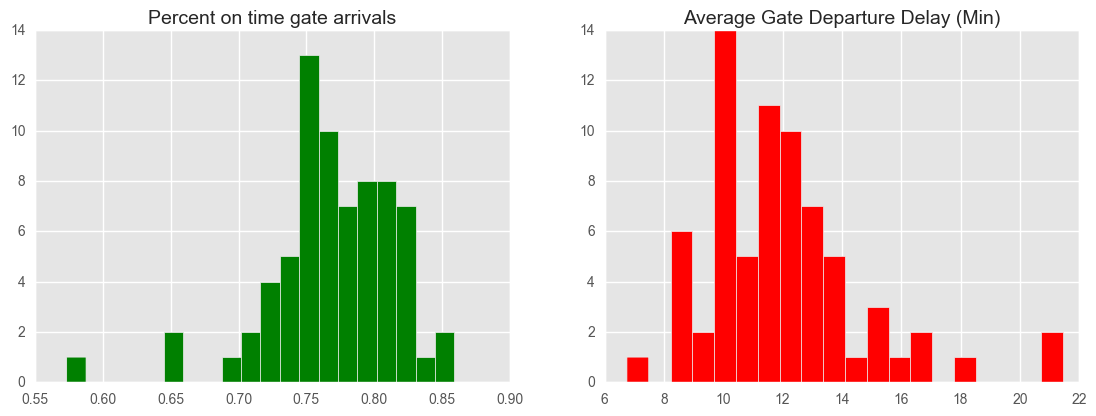

In [213]:
# fig = plt.subplots()

plt.figure(1, figsize=(12,10))
ax1 = plt.subplot(221)
plt.hist(df_04['percent_on-time_airport_departures'], bins=20, color='g')
plt.title('Percent on time airport departures', fontsize = 14)

ax2 = plt.subplot(222)
plt.hist(df_04['average_airport_departure_delay'], bins=20, color='r')
plt.title('Average Airport Departure Delay (Min)', fontsize = 14)


plt.figure(2, figsize=(12,10))

ax1 = plt.subplot(221)
plt.hist(df_04['percent_on-time_gate_arrivals'], bins=20, color='g')
plt.title('Percent on time gate arrivals', fontsize = 14)

ax2 = plt.subplot(222)
plt.hist(df_04['average_gate_departure_delay'], bins=20, color='r')
plt.title('Average Gate Departure Delay (Min)', fontsize = 14)



plt.show()

Let's get a quick look at what airports make up the small outlying range in "Average Departure Delay"...

In [183]:
df_04.describe()

,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
count,71.0,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.00000,71.000000,71.000000,71.000000
mean,2004.0,118986.211268,118353.070423,0.786594,0.733166,0.768585,11.955493,13.886197,4.015915,14.924507,3.390986,1.253803,3.515915,12.886056,1439.00000,1487.070423,160.676056,160.887324
std,0.0,108495.927552,107933.901435,0.046234,0.072346,0.046886,2.641696,3.816634,2.392795,3.819577,1.222009,0.824608,0.971734,2.787079,1881.92605,2064.755180,146.160751,205.576232
min,2004.0,731.000000,717.000000,0.611600,0.548200,0.573200,6.750000,7.240000,0.460000,7.460000,1.170000,0.360000,1.420000,8.420000,43.00000,37.000000,0.000000,0.000000
25%,2004.0,36126.000000,35586.500000,0.765300,0.693350,0.746850,10.250000,11.260000,2.430000,12.685000,2.435000,0.705000,2.815000,10.925000,411.00000,366.000000,58.000000,42.500000
50%,2004.0,92661.000000,92066.000000,0.785700,0.750300,0.770300,11.780000,13.170000,3.180000,14.250000,3.140000,0.930000,3.390000,12.410000,849.00000,797.000000,114.000000,101.000000
75%,2004.0,174511.500000,172449.000000,0.816950,0.770850,0.802300,12.930000,15.770000,4.760000,16.380000,3.995000,1.515000,4.150000,14.025000,1562.50000,1762.000000,246.500000,192.500000
max,2004.0,485187.000000,484859.000000,0.883700,0.877300,0.859100,21.450000,25.930000,12.730000,25.860000,7.580000,4.630000,6.040000,22.620000,11725.00000,12579.000000,737.000000,1154.000000


In [185]:
subset = df_04[df_04['average_airport_departure_delay']>20][['airport', 'departures_for_metric_computation']] 
subset['med_departures'] = 92661
subset['diff'] = subset['departures_for_metric_computation'] - subset['med_departures']
subset.sort('diff')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,airport,departures_for_metric_computation,med_departures,diff
11,ANC,16503,92661,-76158
275,HPN,34104,92661,-58557
341,JFK,151115,92661,58454
374,LGA,196421,92661,103760
220,EWR,212226,92661,119565
286,IAD,212945,92661,120284
583,PHL,225283,92661,132622
22,ATL,477323,92661,384662
539,ORD,485187,92661,392526


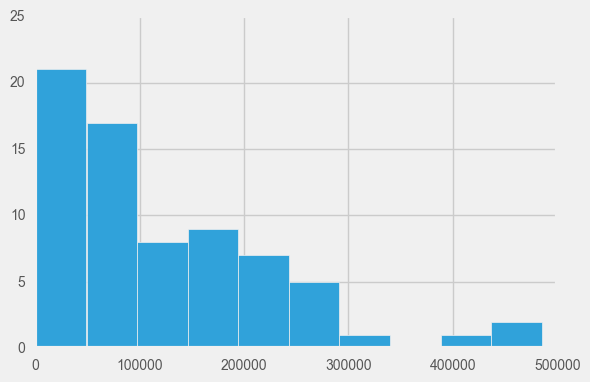

In [186]:
df_04['departures_for_metric_computation'].hist()

At a glance, these look like airports with outlying size values, either very small or ~200,000+. I'll keep an eye on if groupings prove themselves along these size lines in the future...

Same analysis for gate departure delay worst offenders.

In [216]:
subset2 = df_04[df_04['average_gate_departure_delay']>15][['airport', 'departures_for_metric_computation']] 
subset2
subset2['med_departures'] = 92661
subset2['diff'] = subset2['departures_for_metric_computation'] - subset2['med_departures']
subset2.sort('diff')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,airport,departures_for_metric_computation,med_departures,diff
786,SWF,2734,92661,-89927
11,ANC,16503,92661,-76158
275,HPN,34104,92661,-58557
341,JFK,151115,92661,58454
451,MIA,154709,92661,62048
286,IAD,212945,92661,120284
583,PHL,225283,92661,132622
539,ORD,485187,92661,392526


THEORY 1: That airport size (as measured by yearly departures) plays a meaningful role in that airport's performance compared to the whole.

### PCA 

In [187]:
pca = PCA()

In [191]:
my_pca = pca.fit_transform(X)
expVar = pca.explained_variance_ratio_

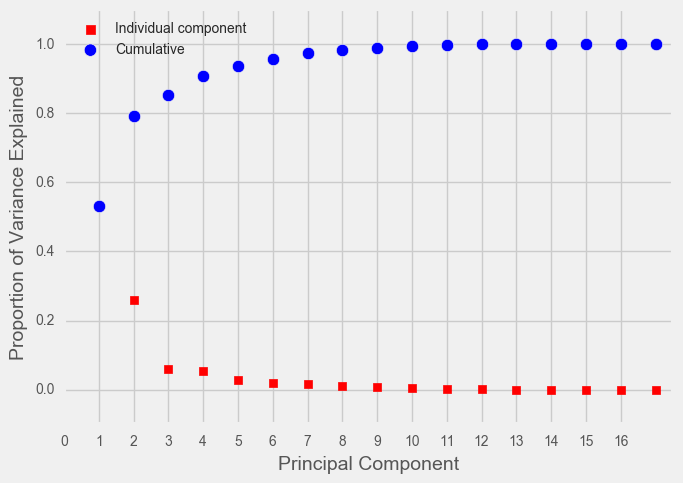

In [193]:

plt.figure(figsize=(7,5))

plt.scatter(range(1,len(expVar)+1), expVar, color='r', s=40, marker='s', label='Individual component')
plt.scatter(range(1,len(expVar)+1), np.cumsum(expVar), s=80, label='Cumulative')

plt.ylabel('Proportion of Variance Explained', fontsize=14)
plt.xlabel('Principal Component', fontsize=14)
plt.xlim(0.5,17.5)
plt.ylim(-0.1,1.1)
plt.xticks(range(len(expVar)))

plt.legend(loc=2);
plt.show()

I am going to move foward with 4 PCA, to capture 90% of the variance. Since I am only working with one year's data, we have rather sparse data, but that's ok for now since my goal is to use one year's worth of data to investigate clusters while retaining interpretability of the unsupervised results. 

In [217]:

my_pca = PCA(n_components=4)
X_pca = my_pca.fit_transform(X)

In [223]:
dumb_clf = DummyClassifier()
log_clf = LogisticRegression()
 

k_vals = range(2,8)

for k in k_vals:
    my_kmean = KMeans(n_clusters=k)
    my_kmean.fit(X_pca)
    labels = my_kmean.labels_
    print k, cross_val_score(log_clf, X_pca, labels, cv=10).mean(), silhouette_score(X_pca, labels) 
    print "dumb_cv", cross_val_score(dumb_clf,X_pca, my_kmean.labels_, cv=5).mean()

2 1.0 0.533808023407
dumb_cv 0.732380952381
3 0.916071428571 0.264145716463
dumb_cv 0.383882783883
4 0.903571428571 0.320516310573
dumb_cv 0.481904761905
5 0.885714285714 0.342397908533
dumb_cv 0.385192307692
6 0.84253968254 0.319225757482
dumb_cv 0.177058823529
7 0.845941558442 0.328528557513
dumb_cv 0.227556022409


//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [227]:
my_kmean = KMeans(n_clusters=2)
my_kmean.fit(X_pca)
labels = my_kmean.labels_

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [232]:
new_labels = []
for i in labels:
    if i == 1:
        new_labels.append('y')
    else:
        new_labels.append('r')


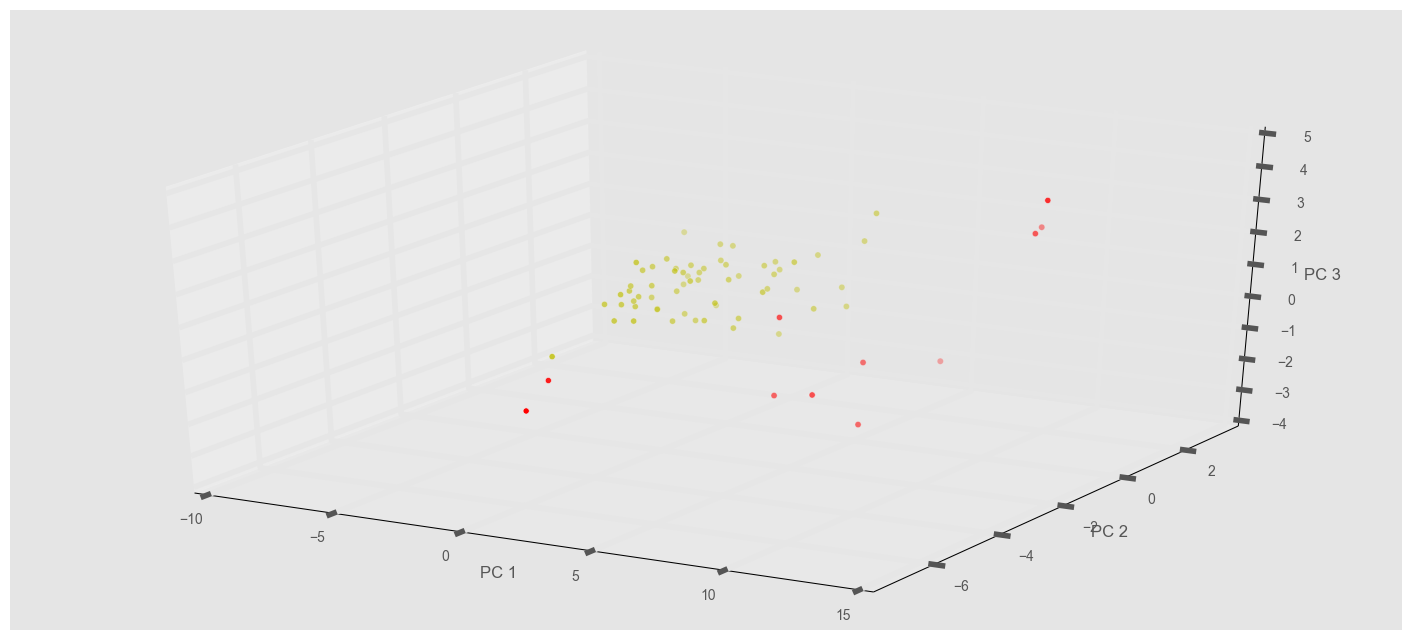

In [234]:
ax = plt.figure(figsize=(16,8)).gca(projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2],  c=new_labels)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.axis('equal')
plt.show()



Who are these "bad ones"? 

In [255]:
df_04['labs'] = labels
df_04[df_04['labs'] ==0]

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,labs
11,ANC,2004,16503,15511,0.7109,0.6770,0.6502,21.45,12.41,2.92,23.05,4.03,1.08,5.93,22.62,473.0,532.0,73.0,30.0,0
22,ATL,2004,477323,473249,0.7596,0.5757,0.7370,13.59,20.45,8.73,21.36,5.00,2.79,4.69,15.31,7870.0,8433.0,737.0,772.0,0
198,DFW,2004,396314,394112,0.8051,0.7152,0.8180,11.21,18.02,6.61,16.46,2.42,4.63,4.34,11.37,5535.0,6147.0,589.0,1154.0,0
220,EWR,2004,212226,209575,0.7921,0.5698,0.7147,12.87,25.93,12.73,23.59,5.93,2.21,6.04,18.54,3883.0,3981.0,295.0,418.0,0
275,HPN,2004,34104,33880,0.6116,0.5583,0.5732,20.80,14.22,4.88,24.10,4.30,1.73,5.73,22.43,349.0,315.0,24.0,47.0,0
286,IAD,2004,212945,215986,0.7261,0.6179,0.7484,15.71,18.82,7.17,21.45,5.05,1.28,3.79,15.09,2856.0,3197.0,271.0,260.0,0
297,IAH,2004,247146,246368,0.8607,0.6809,0.8084,8.39,21.45,9.56,16.32,3.37,3.81,5.42,11.19,1825.0,2010.0,344.0,885.0,0
341,JFK,2004,151115,148127,0.7543,0.6028,0.7461,15.07,23.79,8.75,22.43,3.64,2.95,4.65,14.91,1340.0,1194.0,218.0,211.0,0
374,LGA,2004,196421,196310,0.7963,0.6210,0.7518,12.44,23.28,10.18,20.77,5.29,2.42,4.57,15.47,4347.0,4241.0,265.0,449.0,0
539,ORD,2004,485187,484859,0.7179,0.5739,0.7210,17.79,20.23,9.36,25.86,3.19,3.34,5.81,19.19,11725.0,12579.0,700.0,648.0,0


Those look familiar. Let's keep going with this analysis and take a cohesive look at this data at the end. 

### Examine Variance along the PCs

In [273]:
sorted([i for i in zip(features, my_pca.components_[0])], key=lambda x: x[1], reverse = True )


[('average_taxi_out_delay', 0.29399591301845218),
 ('average_taxi_out_time', 0.28081572413547662),
 ('departure_cancellations', 0.27927856832400749),
 ('departure_diversions', 0.27748811267842732),
 ('average_airport_departure_delay', 0.27591418022522796),
 ('arrival_cancellations', 0.27502988826696567),
 ('departures_for_metric_computation', 0.27329433551716781),
 ('arrivals_for_metric_computation', 0.27319590587039866),
 ('average_taxi_in_delay', 0.27302803896712918),
 ('arrival_diversions', 0.26104822921181148),
 ('average_block_delay', 0.2420020912318577),
 ('average_airborne_delay', 0.17309323152912989),
 ('average_gate_departure_delay', 0.1560637479163022),
 ('average_gate_arrival_delay', 0.15361825540230642),
 ('percent_on-time_gate_arrivals', -0.088739744385449876),
 ('percent_on-time_gate_departures', -0.12538958574875569),
 ('percent_on-time_airport_departures', -0.27540582864408469)]

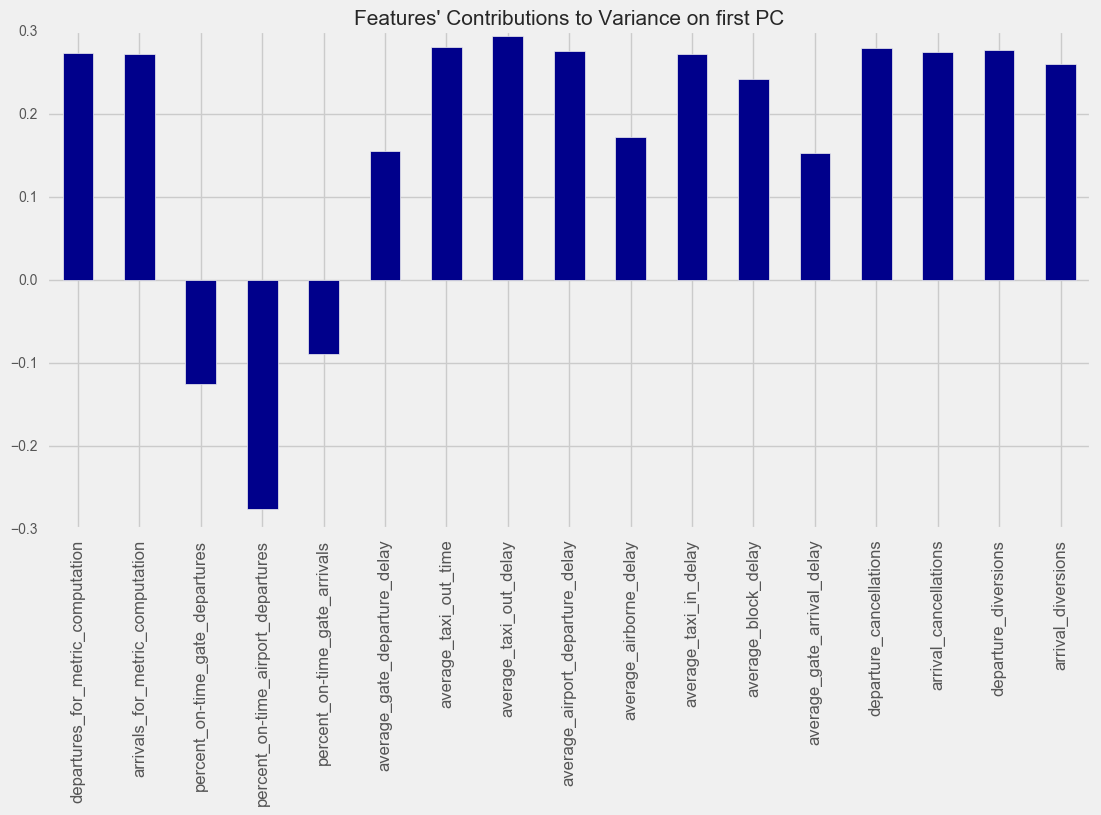

In [275]:
plt.figure(figsize=[12,6])
ax =  pd.Series(my_pca.components_[0]).plot(kind = 'bar', color ='darkblue')
ax.set_xticklabels(features, fontsize = 12)
plt.title("Features' Contributions to Variance on first PC", fontsize=15)
plt.show()

#### A look at PC2

In [243]:
sorted([i for i in zip(features, my_pca.components_[1])], key=lambda x: x[1], reverse = True )


[('percent_on-time_gate_arrivals', 0.42661546020654673),
 ('percent_on-time_gate_departures', 0.37688851568357673),
 ('arrivals_for_metric_computation', 0.23180020822893227),
 ('departures_for_metric_computation', 0.23127279262249228),
 ('percent_on-time_airport_departures', 0.21740387739115744),
 ('departure_diversions', 0.21494207385333022),
 ('arrival_diversions', 0.19981801336642666),
 ('arrival_cancellations', 0.15179975709894289),
 ('departure_cancellations', 0.146120216574744),
 ('average_taxi_in_delay', 0.11274547402461008),
 ('average_taxi_out_time', 0.040105766642798163),
 ('average_taxi_out_delay', 0.019147882957754506),
 ('average_airborne_delay', -0.015609691828406207),
 ('average_block_delay', -0.13800678600185115),
 ('average_airport_departure_delay', -0.24815371174095741),
 ('average_gate_departure_delay', -0.38318063957666865),
 ('average_gate_arrival_delay', -0.38544251552563646)]

Our PCA analysis would suggest that the most variance is added by taxi delays (in raw or average), though only narrowly compared to our other delay measures. Very closely second/third are departure cancellations and departure diversions. PC2 is dominated by percent on-time gate arrivals, meaning it is the second greatest contributor of variance to our data while being the least correlated with taxi time (due to the orthogonality of pc2 position).

THEORY 2: Taxi out delays, departure cancellations, and departure diversions can all be summarized as "getting out" problems, as opposed to number of flights or in-flight delays. This would suggest that factors likely to cause ground level delay like bad weather are very correlated with travel delay. 

## Hierarchical Clustering

Let's see if a hierarchical cluster can lend credence to any of the above theories...

In [200]:
from scipy.cluster import hierarchy


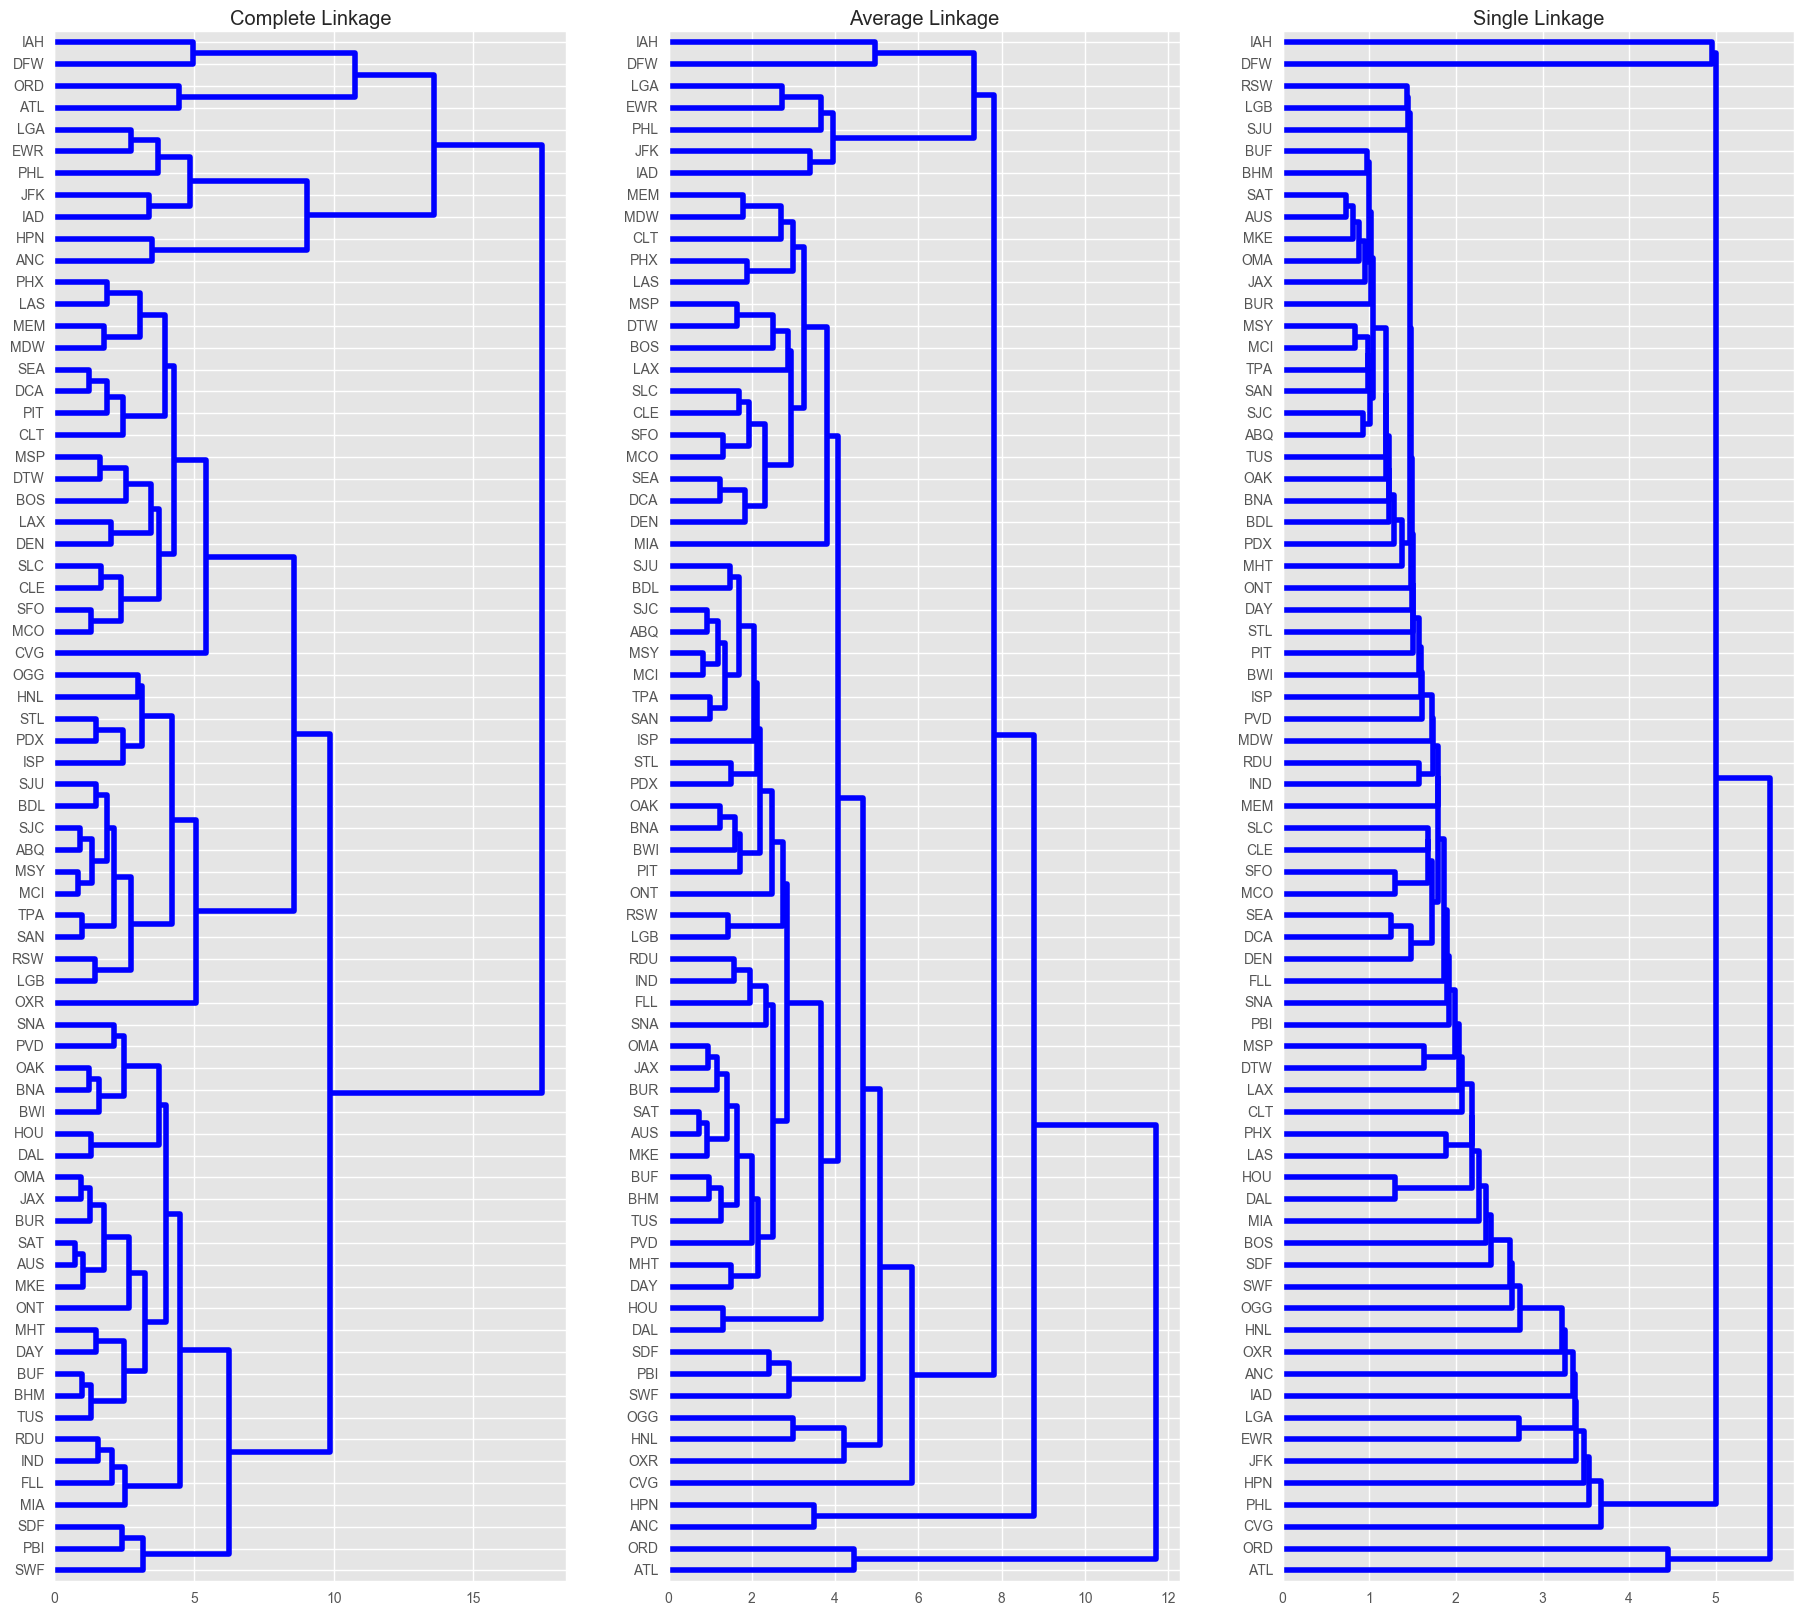

In [209]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)],
                                ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, labels=df_04['airport'].values, orientation='right', color_threshold=0, leaf_font_size=10, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');

I am going to pursue the complete linkage, since at its highest split, it actually generates a meaningful division. Average and single are less appropriate here. 

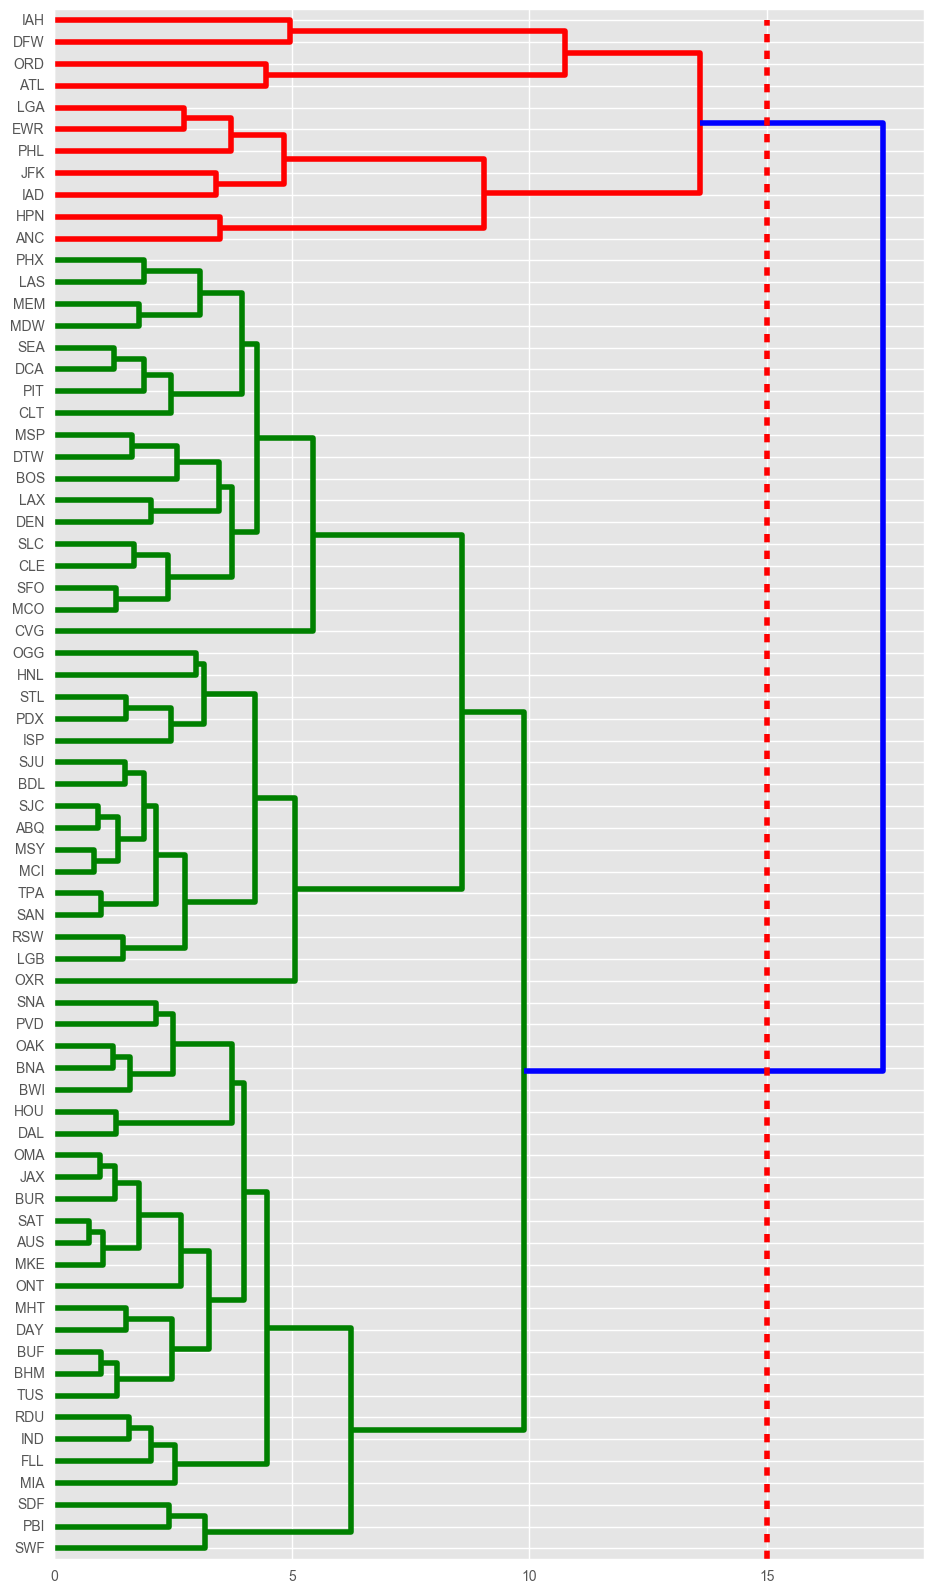

In [212]:
plt.figure(figsize=(10,20))
cut4 = hierarchy.dendrogram(hierarchy.complete(X), labels=df_04['airport'].values,
                             orientation='right', color_threshold=15, leaf_font_size=10)
plt.vlines(15,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed')

In [278]:
max_dist = 15
clusters = fcluster(hierarchy.complete(X), max_dist, criterion='distance')
clusters

71

In [292]:
new_clusters = [0 if i == 2  else i for i in clusters]


In [293]:
df_04['dendo'] = new_clusters

In [301]:
df_04[df_04['dendo']==0]

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,...,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,labs,dendo
11,ANC,2004,16503,15511,0.7109,0.6770,0.6502,21.45,12.41,2.92,...,4.03,1.08,5.93,22.62,473.0,532.0,73.0,30.0,0,0
22,ATL,2004,477323,473249,0.7596,0.5757,0.7370,13.59,20.45,8.73,...,5.00,2.79,4.69,15.31,7870.0,8433.0,737.0,772.0,0,0
198,DFW,2004,396314,394112,0.8051,0.7152,0.8180,11.21,18.02,6.61,...,2.42,4.63,4.34,11.37,5535.0,6147.0,589.0,1154.0,0,0
220,EWR,2004,212226,209575,0.7921,0.5698,0.7147,12.87,25.93,12.73,...,5.93,2.21,6.04,18.54,3883.0,3981.0,295.0,418.0,0,0
275,HPN,2004,34104,33880,0.6116,0.5583,0.5732,20.80,14.22,4.88,...,4.30,1.73,5.73,22.43,349.0,315.0,24.0,47.0,0,0
286,IAD,2004,212945,215986,0.7261,0.6179,0.7484,15.71,18.82,7.17,...,5.05,1.28,3.79,15.09,2856.0,3197.0,271.0,260.0,0,0
297,IAH,2004,247146,246368,0.8607,0.6809,0.8084,8.39,21.45,9.56,...,3.37,3.81,5.42,11.19,1825.0,2010.0,344.0,885.0,0,0
341,JFK,2004,151115,148127,0.7543,0.6028,0.7461,15.07,23.79,8.75,...,3.64,2.95,4.65,14.91,1340.0,1194.0,218.0,211.0,0,0
374,LGA,2004,196421,196310,0.7963,0.6210,0.7518,12.44,23.28,10.18,...,5.29,2.42,4.57,15.47,4347.0,4241.0,265.0,449.0,0,0
539,ORD,2004,485187,484859,0.7179,0.5739,0.7210,17.79,20.23,9.36,...,3.19,3.34,5.81,19.19,11725.0,12579.0,700.0,648.0,0,0


This dendogram has given us an identical match of the "outlier" group that the kmeans in our reduced dimensional space did. A few summary statistics should help us see what these have in common and how they compare to the rest of the group.

Median comparison for "Percent on time airport departures":

In [311]:
print "Bad Ones: ", df_04[df_04['dendo']==0]['percent_on-time_airport_departures'].median()

Bad Ones:  0.6028


In [310]:
print "The rest: ", df_04[df_04['dendo']==1]['percent_on-time_airport_departures'].median()

The rest:  0.75915


In [309]:
df_04[df_04['dendo']==0].describe()

,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,labs,dendo
count,11.0,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.0
mean,2004.0,241324.272727,240214.363636,0.749836,0.612791,0.727127,15.090909,19.998182,8.243636,21.840000,4.527273,2.607273,5.084545,16.591818,3914.181818,4123.181818,342.090909,481.181818,0.0,0.0
std,0.0,156450.763824,155925.660529,0.065519,0.055965,0.067964,3.967391,4.010972,2.705861,3.100726,1.449814,1.063504,0.744182,3.813693,3424.353014,3707.556333,235.853113,353.701800,0.0,0.0
min,2004.0,16503.000000,15511.000000,0.611600,0.548200,0.573200,8.390000,12.410000,2.920000,16.320000,2.420000,1.080000,3.790000,11.190000,349.000000,315.000000,24.000000,30.000000,0.0,0.0
25%,2004.0,173768.000000,172218.500000,0.715750,0.571850,0.717850,12.655000,18.420000,6.890000,21.065000,3.505000,1.970000,4.610000,15.000000,1582.500000,1602.000000,232.500000,235.500000,0.0,0.0
50%,2004.0,212945.000000,215986.000000,0.754300,0.602800,0.737000,15.070000,20.450000,8.750000,22.430000,4.300000,2.440000,4.960000,15.470000,2856.000000,3197.000000,271.000000,419.000000,0.0,0.0
75%,2004.0,321730.000000,320240.000000,0.794200,0.649000,0.750100,17.235000,22.365000,9.675000,23.845000,5.170000,3.145000,5.770000,18.865000,4941.000000,5194.000000,466.500000,710.000000,0.0,0.0
max,2004.0,485187.000000,484859.000000,0.860700,0.715200,0.818000,21.450000,25.930000,12.730000,25.860000,7.580000,4.630000,6.040000,22.620000,11725.000000,12579.000000,737.000000,1154.000000,0.0,0.0


In [307]:
df_04[df_04['dendo']==1].describe()

,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,labs,dendo
count,60.0,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.0,60.0
mean,2004.0,96557.566667,96011.833333,0.793333,0.755235,0.776185,11.380667,12.765667,3.240833,13.656667,3.182667,1.005667,3.228333,12.206667,985.216667,1003.783333,127.416667,102.166667,1.0,1.0
std,0.0,80718.381085,80153.772162,0.038864,0.049821,0.038027,1.855512,2.512797,1.268329,2.264640,1.063297,0.459238,0.695407,1.929040,928.880556,1093.209675,93.041323,79.393926,0.0,0.0
min,2004.0,731.000000,717.000000,0.690800,0.643100,0.652500,6.750000,7.240000,0.460000,7.460000,1.170000,0.360000,1.420000,8.420000,43.000000,37.000000,0.000000,0.000000,1.0,1.0
25%,2004.0,20865.500000,20922.500000,0.774650,0.724825,0.749550,10.200000,10.862500,2.385000,12.307500,2.397500,0.695000,2.682500,10.712500,398.250000,353.750000,53.750000,38.750000,1.0,1.0
50%,2004.0,81740.500000,82150.500000,0.794800,0.759150,0.775250,11.340000,12.885000,3.040000,13.625000,3.025000,0.855000,3.195000,12.165000,750.500000,679.500000,100.000000,83.000000,1.0,1.0
75%,2004.0,150242.250000,145691.500000,0.821600,0.779775,0.806575,12.350000,14.050000,3.955000,15.220000,3.785000,1.210000,3.550000,13.280000,1304.750000,1351.750000,167.000000,139.000000,1.0,1.0
max,2004.0,307973.000000,307061.000000,0.883700,0.877300,0.859100,16.630000,18.200000,6.670000,18.900000,5.660000,2.410000,4.690000,18.670000,5656.000000,7136.000000,382.000000,320.000000,1.0,1.0


Outlier group percent on time vs Main group


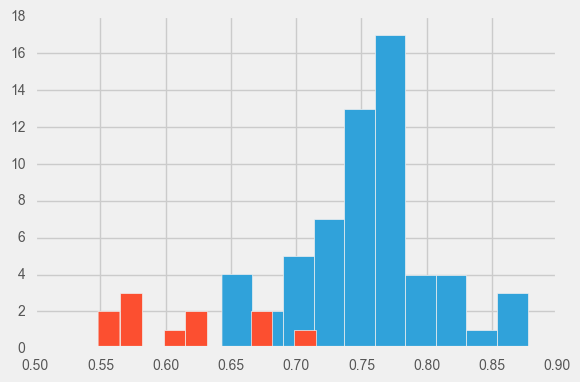

In [319]:
df_04[df_04['dendo']==1]['percent_on-time_airport_departures'].hist()
df_04[df_04['dendo']==0]['percent_on-time_airport_departures'].hist()
print "Outlier group percent on time vs Main group"


Outlier group taxi out delay vs Main group


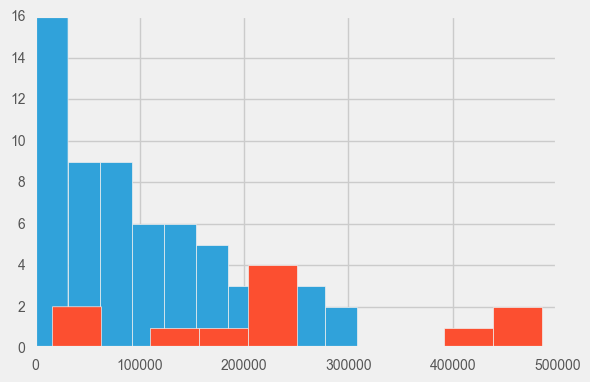

In [321]:
df_04[df_04['dendo']==1]['departures_for_metric_computation'].hist()
df_04[df_04['dendo']==0]['departures_for_metric_computation'].hist()
print "Outlier group taxi out delay vs Main group"


In [ ]:
df_04[df_04['dendo']==1]['average_taxi_out_delay'].hist()
df_04[df_04['dendo']==0]['average_taxi_out_delay'].hist()
print "Outlier group taxi out delay vs Main group"


### Conclusions

Given that the two unsupervised methods agreed so heartily about the group belonging of these "poor performers", it is safe to say that there is meaningful grouping signal to pursue here. 

Theories:
* Airport size is a meaningful indicator of "goodness"
* Airports in areas with worse weather conditions are likely to be penalized here

The above summary stats represent some cursory visualizations of these theories. Next steps for this project would include a much more robust comparative EDA and group-comparison statistics treating the groups formed in the above clustering as distinct.  

Other next steps would include running further PCA analysis on the groups independently of one another to see what features cause the most variance amongst the "good" or "poor" performers. 

Finally, integrating over time analysis for each airport would prove an interesting case study for how industry advancements change the causes of flight delay. 
